## Objective

The goal of this notebook is to load the raw Bitcoin market data from the **Bronze Delta table**, perform data cleaning and transformation, and write the results into a curated **Silver Delta table** that will be used for further analysis and aggregation in the Gold layer.

## Tools & Technologies Used

- **Apache Spark**: Distributed processing engine for large-scale data.
- **Delta Lake**: Storage layer that brings ACID transactions to Apache Spark.
- **PySpark SQL**: For data transformation and querying.
- **Unity Catalog**: For organizing data into catalogs, schemas, and tables.
- **Databricks Visualizations**: For quick in-notebook plotting and inspection.

In [0]:
# Load raw data from the Bronze Delta table
df_bronze = spark.table("bitcoin.market_data.bronze_bitcoin")

# Print schema and preview data
df_bronze.printSchema()
df_bronze.show(10)

root
 |-- Date: date (nullable = true)
 |-- Close: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: long (nullable = true)

+----------+------------------+------------------+------------------+-----------------+--------+
|      Date|             Close|              High|               Low|             Open|  Volume|
+----------+------------------+------------------+------------------+-----------------+--------+
|2014-09-17| 457.3340148925781|468.17401123046875| 452.4219970703125| 465.864013671875|21056800|
|2014-09-18|424.44000244140625| 456.8599853515625|   413.10400390625|456.8599853515625|34483200|
|2014-09-19| 394.7959899902344| 427.8349914550781| 384.5320129394531|424.1029968261719|37919700|
|2014-09-20|408.90399169921875| 423.2959899902344|389.88299560546875|394.6730041503906|36863600|
|2014-09-21| 398.8210144042969| 412.4259948730469| 393.1809997558594|408.0849914550781|26580100|
|201

In [0]:
from pyspark.sql.functions import col, year, month

# Basic cleaning: remove nulls, rename columns, add year/month
df_silver = df_bronze \
    .filter("Volume IS NOT NULL AND Close IS NOT NULL") \
    .withColumnRenamed("Date", "market_date") \
    .withColumnRenamed("Close", "close") \
    .withColumnRenamed("High", "high") \
    .withColumnRenamed("Low", "low") \
    .withColumnRenamed("Open", "open") \
    .withColumnRenamed("Volume", "volume") \
    .withColumn("year", year("market_date")) \
    .withColumn("month", month("market_date"))

# Preview cleaned DataFrame
df_silver.show(10)

+-----------+------------------+------------------+------------------+-----------------+--------+----+-----+
|market_date|             close|              high|               low|             open|  volume|year|month|
+-----------+------------------+------------------+------------------+-----------------+--------+----+-----+
| 2014-09-17| 457.3340148925781|468.17401123046875| 452.4219970703125| 465.864013671875|21056800|2014|    9|
| 2014-09-18|424.44000244140625| 456.8599853515625|   413.10400390625|456.8599853515625|34483200|2014|    9|
| 2014-09-19| 394.7959899902344| 427.8349914550781| 384.5320129394531|424.1029968261719|37919700|2014|    9|
| 2014-09-20|408.90399169921875| 423.2959899902344|389.88299560546875|394.6730041503906|36863600|2014|    9|
| 2014-09-21| 398.8210144042969| 412.4259948730469| 393.1809997558594|408.0849914550781|26580100|2014|    9|
| 2014-09-22| 402.1520080566406| 406.9159851074219| 397.1300048828125|399.1000061035156|24127600|2014|    9|
| 2014-09-23| 435.7

In [0]:
df_silver.write.format("delta") \
.mode("overwrite") \
.saveAsTable("bitcoin.market_data.silver_bitcoin")

spark.table("bitcoin.market_data.silver_bitcoin").show(10)

+-----------+------------------+------------------+------------------+-----------------+--------+----+-----+
|market_date|             close|              high|               low|             open|  volume|year|month|
+-----------+------------------+------------------+------------------+-----------------+--------+----+-----+
| 2014-09-17| 457.3340148925781|468.17401123046875| 452.4219970703125| 465.864013671875|21056800|2014|    9|
| 2014-09-18|424.44000244140625| 456.8599853515625|   413.10400390625|456.8599853515625|34483200|2014|    9|
| 2014-09-19| 394.7959899902344| 427.8349914550781| 384.5320129394531|424.1029968261719|37919700|2014|    9|
| 2014-09-20|408.90399169921875| 423.2959899902344|389.88299560546875|394.6730041503906|36863600|2014|    9|
| 2014-09-21| 398.8210144042969| 412.4259948730469| 393.1809997558594|408.0849914550781|26580100|2014|    9|
| 2014-09-22| 402.1520080566406| 406.9159851074219| 397.1300048828125|399.1000061035156|24127600|2014|    9|
| 2014-09-23| 435.7

In [0]:
# Load from saved Delta table to ensure we're validating persisted data
df_silver_table = spark.table("bitcoin.market_data.silver_bitcoin")

# Check distribution of year and month
df_silver_table.groupBy("year", "month").count().orderBy("year", "month").show()

# Preview statistical ranges
df_silver_table.select("close", "volume").describe().show()


+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2014|    9|   14|
|2014|   10|   31|
|2014|   11|   30|
|2014|   12|   31|
|2015|    1|   31|
|2015|    2|   28|
|2015|    3|   31|
|2015|    4|   30|
|2015|    5|   31|
|2015|    6|   30|
|2015|    7|   31|
|2015|    8|   31|
|2015|    9|   30|
|2015|   10|   31|
|2015|   11|   30|
|2015|   12|   31|
|2016|    1|   31|
|2016|    2|   29|
|2016|    3|   31|
|2016|    4|   30|
+----+-----+-----+
only showing top 20 rows
+-------+------------------+--------------------+
|summary|             close|              volume|
+-------+------------------+--------------------+
|  count|              3966|                3966|
|   mean| 23700.72091550149|2.005691719364170...|
| stddev| 27883.04342466844|2.142795819073010...|
|    min|178.10299682617188|             5914570|
|    max|    119995.4140625|        350967941479|
+-------+------------------+--------------------+



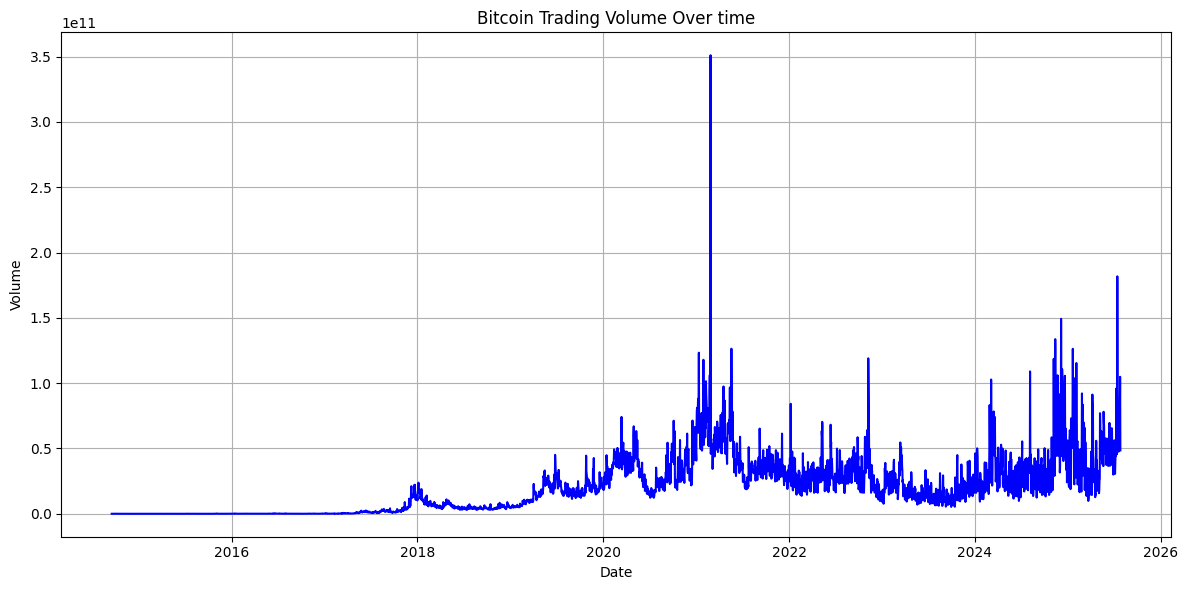

In [0]:
import matplotlib.pyplot as plt

#Load Data
df_silver = spark.table("bitcoin.market_data.silver_bitcoin")

#Select only necessary columns and order
df_pd = df_silver.select("market_date", "volume") \
                . orderBy("market_date") \
                . toPandas()

# Set figure size
plt.figure(figsize=(12, 6))   

#Plot line
plt.plot(df_pd["market_date"], df_pd["volume"], color='blue')

#Labels and title 
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Bitcoin Trading Volume Over time")

#Grid & layout
plt.grid(True)
plt.tight_layout()

#Show the chart
plt.show()

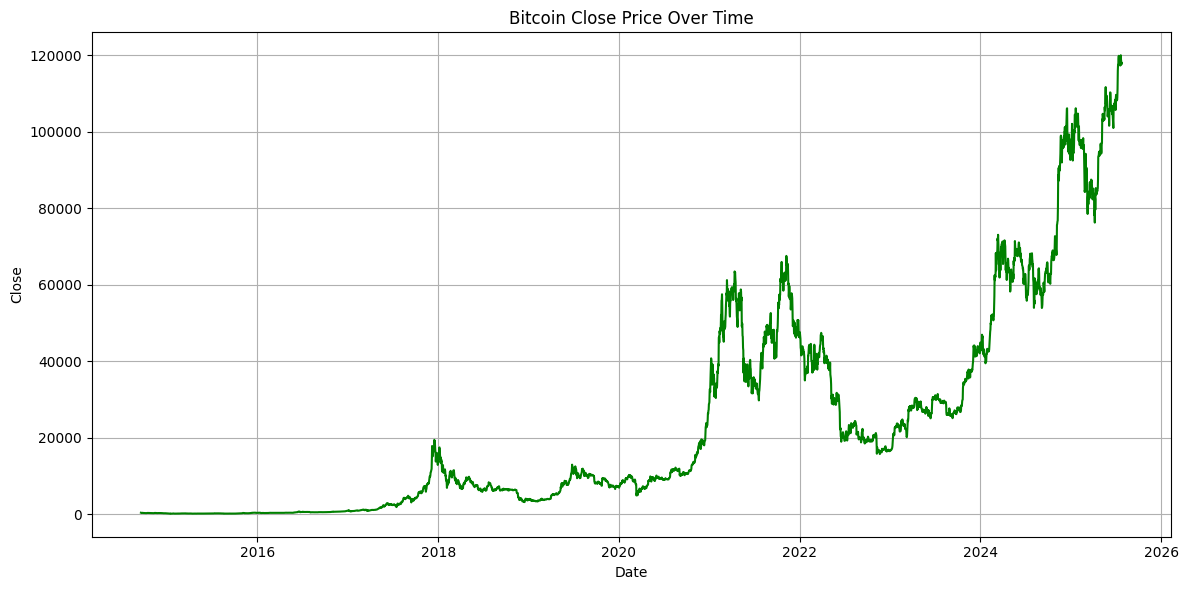

In [0]:
import matplotlib.pyplot as plt

# Load your Silver table
df_silver = spark.table("bitcoin.market_data.silver_bitcoin")

# Convert to Pandas (only 'market_date' and 'close' column needed)
df_pd = df_silver.select("market_date", "close").orderBy("market_date").dropna().toPandas()

# Set figure size
plt.figure(figsize=(12, 6))

# Plot histogram
plt.plot(df_pd["market_date"], df_pd["close"], color='green')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Bitcoin Close Price Over Time")

# Show grid and plot
plt.grid(True)
plt.tight_layout()


plt.show()


In [0]:
import dlt
from pyspark.sql.functions import col, year, month

@dlt.table(
    name="silver_bitcoin_data",
    comment="Cleaned and transformed Bitcoin data"
)
def transform_bitcoin_data():
    df = dlt.read("bronze_bitcoin_historical")

    # Filter rows with non-null 'close' and 'volume' values
    df_cleaned = df.filter((col("Close").isNotNull()) & (col("Volume").isNotNull()))

    # Add year and month columns
    df_transformed = df_cleaned.withColumn("year", year("Date")) \
                               .withColumn("month", month("Date"))

    return df_transformed


The Delta Live Tables (DLT) module is not supported on this cluster.
 You should either create a new pipeline or use an existing pipeline to run DLT code.

The Delta Live Tables (DLT) module is not supported on this cluster.
 You should either create a new pipeline or use an existing pipeline to run DLT code.

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-4927979449718655>, line 1
----> 1 import dlt
      2 from pyspark.sql.functions import col, year, month
      4 @dlt.table(
      5     name="silver_bitcoin_data",
      6     comment="Cleaned and transformed Bitcoin data"
      7 )
      8 def transform_bitcoin_data():

File /databricks/python_shell/lib/dbruntime/autoreload/discoverability/hook.py:71, in AutoreloadDiscoverabilityHook._patched_import(self, name, *args, **kwargs)
     65 if not self._should_hint and (
     66     (module := sys.modules.get(absolute_name)) is not None and
     67     (fname := get_allowed_file_name_or_none(module)) is not None and
     68     (mtime := os.stat(fname).st_mtime) > self.last_mtime_by_modname.get(
     69         absolute_name, float("inf")) and not self._should_hint):
     70     self._should_hint = True
---> 71 module = self._